In [68]:
import time 
import pandas as pd #pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
import numpy as np #numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
import re #re: 正規表達式套件。
import math #math: 數學運算工具。
import datetime
from pprint import pprint
from collections import defaultdict
import multiprocessing
import os
from getpass import getpass
import seaborn as sns
from matplotlib import font_manager
import matplotlib.pyplot as plt  #matplotlib: 繪圖工具。
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
import jieba #jieba: 中文斷詞套件。
import jieba.analyse

import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker 
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from wordcloud import WordCloud 
from nltk import ngrams, FreqDist #NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
from collections import Counter, namedtuple #collections: 提供額外的數據類型。
import networkx as nx #networkx: 網絡圖建構、繪製工具。
from snownlp import SnowNLP #SnowNLP 針對中文設計，可以提取句子的情緒分類
# from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer #CountVectorizer, TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
import guidedlda

In [69]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
plt.rcParams['axes.unicode_minus']=False

In [70]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

1. LDA

In [72]:
df = pd.read_csv('./self_data/ppt_tesla.csv', encoding = 'UTF-8')
df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
df = df[['artDate','artTitle','artContent']]
df['artDate'] = pd.to_datetime(df['artDate'])
df.head(3)

,artDate,artTitle,artContent
0,2023-01-01 10:48:19,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....
1,2023-01-01 22:42:25,[問題]特斯拉久了會掉電嗎？,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...
2,2023-01-02 12:47:31,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,原文連結：\nhttps://star.setn.com/news/1232578?utm_...


In [273]:
# MetaData = df.copy()
# MetaData.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
# #MetaData['artDate'] =  pd.to_datetime(MetaData['artDate']).dt.to_period('D')

# # 只留下中文字
# MetaData['artContent'] = MetaData['artContent'].str.replace("(http|https)://.*", "", regex=True)
# MetaData['artTitle'] = MetaData['artTitle'].str.replace("(http|https)://.*", "", regex=True)
# MetaData['artContent'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
# MetaData['artTitle'] = MetaData['artTitle'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))


# MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
# MetaData['sentence'] = MetaData['sentence'].apply(lambda x: re.sub('[口]', '', x))

# MetaData.head(3)
car = df.copy()
car["artContent"] = car["artContent"].str.replace("(http|https)://.*", "", regex=True)
car["artTitle"] = car["artTitle"].str.replace("(http|https)://.*", "", regex=True)
car["artContent"] = car["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
car["artTitle"] = car["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
car['content'] = car['artContent']
car['topic_label']= ""
car

,artDate,artTitle,artContent,content,topic_label
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,
1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,
2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,
3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,
4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,
...,...,...,...,...,...
1581,2024-04-30 10:33:35,新聞特斯拉全新入門電動車準備量產,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,
1582,2024-04-30 12:24:31,分享撞緩撞車啦,要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...,要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...,
1583,2024-04-30 17:45:19,新聞銷售降溫賓士上季獲利銳減逾三成福斯,都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...,都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...,
1584,2024-04-30 19:19:58,問題,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,


In [274]:
# raw_data = MetaData.copy()
# raw_data['content'] = raw_data['artContent']
# raw_data = raw_data.loc[:,["artDate", "content", ]]  # 文章內容 文章連結
# raw_data.head(3)

In [275]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

car["words"] = car["content"].apply(getToken)
car.head()

Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/林冠杰/dict/dict.txt.big ...
2024-06-04 21:56:14,426 : DEBUG : Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/林冠杰/dict/dict.txt.big ...
Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub01331ea77fae58ed018653e93caa352.cache
2024-06-04 21:56:14,427 : DEBUG : Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub01331ea77fae58ed018653e93caa352.cache
Loading model cost 0.565 seconds.
2024-06-04 21:56:14,992 : DEBUG : Loading model cost 0.565 seconds.
Prefix dict has been built successfully.
2024-06-04 21:56:14,992 : DEBUG : Prefix dict has been built successfully.


,artDate,artTitle,artContent,content,topic_label,words
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,,"[特斯拉, 二手車, 第三方, 平台, 便宜, 黨會, 勝利]"
1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,,"[中古, 特斯拉, 里程, 擔心, 電池, 掉電, 越充, 越少電, 里程, 數越, 少開,..."
2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,,"[王家, 徐兆緯, 台北, 前電, 世界冠軍, 日前, 直播, 自動, 駕駛, 雙手, 離開..."
3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,,"[特斯拉, 出門, 車位, 很煩, 騎家裡, 超舊, 路上, 有機, 車道, 靠邊, 不爭,..."
4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,,"[美國, 召回, 排名, 揭曉, 第一名, 超過, 進廠, 結束, 迎來, 許多年, 數據,..."


In [276]:
docs = car['words'].to_list()
docs[0]

['特斯拉', '二手車', '第三方', '平台', '便宜', '黨會', '勝利']

In [277]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2024-06-04 21:56:20,755 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-06-04 21:56:20,816 : INFO : built Dictionary<28495 unique tokens: ['二手車', '便宜', '勝利', '平台', '特斯拉']...> from 1585 documents (total 170328 corpus positions)
2024-06-04 21:56:20,816 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<28495 unique tokens: ['二手車', '便宜', '勝利', '平台', '特斯拉']...> from 1585 documents (total 170328 corpus positions)", 'datetime': '2024-06-04T21:56:20.816761', 'gensim': '4.3.2', 'python': '3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]', 'platform': 'macOS-14.5-arm64-arm-64bit', 'event': 'created'}
2024-06-04 21:56:20,823 : INFO : discarding 23867 tokens: [('黨會', 1), ('寵物', 4), ('少開', 1), ('掉電', 4), ('數越', 1), ('有載', 2), ('沒人收', 1), ('越充', 1), ('越少電', 1), ('一拳', 2)]...
2024-06-04 21:56:20,823 : INFO : keeping 4628 tokens which were in no less than 5 and no more than 1569 (=99.0%) documents
2024-06-04 21:56:20,826 : INFO : resulting dictionary: Dictionary<462

Dictionary<4628 unique tokens: ['二手車', '便宜', '勝利', '平台', '特斯拉']...>


In [278]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

二手車: 0
便宜: 1
勝利: 2
平台: 3
特斯拉: 4
第三方: 5
中古: 6
利率: 7
垃圾: 8
建議: 9
想要: 10
擔心: 11


In [279]:
corpus = [dictionary.doc2bow(doc) for doc in docs]
type(corpus)

list

In [280]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('二手車', '便宜', '勝利', '平台', '特斯拉', '第三方', '中古', '利率', '垃圾', '建議')

In [281]:
word2id = dictionary.token2id

In [294]:
seed_topic_list = [
    ["服務", "員工", "品質", "後勤", "更換", "速度","態度"],
    ["設備", "交付", "延遲", "據點","原廠"],
    ["價格","優惠","打折","折價"],
    ["安全", "過熱", "火車", "爆炸", "失控","召回","系統","自駕","煞車"],
    ["體驗", "駕駛", "操控", "公差","里程","續航力","加速","噪音","焦慮"],
]

In [295]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [296]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [299]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-06-04 21:59:02,421 : INFO : n_documents: 1585
2024-06-04 21:59:02,422 : INFO : vocab_size: 4628
2024-06-04 21:59:02,422 : INFO : n_words: 129403
2024-06-04 21:59:02,422 : INFO : n_topics: 6
2024-06-04 21:59:02,423 : INFO : n_iter: 100
2024-06-04 21:59:02,428 : WARNING : all zero row in document-term matrix found
2024-06-04 21:59:02,885 : INFO : <0> log likelihood: -1340619
2024-06-04 21:59:03,001 : INFO : <20> log likelihood: -1041079
2024-06-04 21:59:03,115 : INFO : <40> log likelihood: -1022746
2024-06-04 21:59:03,226 : INFO : <60> log likelihood: -1014236
2024-06-04 21:59:03,335 : INFO : <80> log likelihood: -1010107
2024-06-04 21:59:03,446 : INFO : <99> log likelihood: -1008352


In [300]:
# 整理／顯示主題模型結果
n_top_words = 20
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 電動車 電池 特斯拉 美國 技術 中國 製造商 成本 車廠 電動 傳統 豐田 消費者 歐洲 福特 製造 系統 軟體 產業 發展
Topic 1: 特斯拉 車主 原廠 維修 台灣 車體 根本 車輛 電池 這種 有人 玻璃 保險公司 無法 理賠 辦法 保費 產險 只能 費用
Topic 2: 中國 特斯拉 台灣 電動車 銷售 降價 銷量 價格 比亞迪 日本 電車 美國 售價 新車 歐洲 豐田 德國 成長 車廠 台幣
Topic 3: 駕駛 特斯拉 自動 車輛 輔助 安全 車主 車道 系統 功能 測試 煞車 警方 召回 車禍 事故 造成 一輛 方向盤 注意
Topic 4: 電車 充電 特斯拉 油車 空間 里程 電池 後座 保養 加速 朋友 業務 價格 功能 原廠 左右 超充 這種 不錯 輪胎
Topic 5: 充電 電動車 車主 報名 車馬費 活動 超充 規格 停車場 台北 充電站 購買 停車 車位 專案 車款 資料 購車 座談會 快充


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.023400 -0.073399       1        1  27.399335
0      0.013662 -0.167808       2        1  19.834548
2      0.113505 -0.191300       3        1  17.732486
3      0.105604  0.292693       4        1  15.904584
1      0.169290  0.080885       5        1  12.303328
5     -0.378661  0.058929       6        1   6.825719, topic_info=     Term         Freq        Total Category  logprob  loglift
387    充電  1397.000000  1397.000000  Default  30.0000  30.0000
18    電動車  2135.000000  2135.000000  Default  29.0000  29.0000
82     駕駛   976.000000   976.000000  Default  28.0000  28.0000
326    中國  1161.000000  1161.000000  Default  27.0000  27.0000
4     特斯拉  3048.000000  3048.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
255    車款    73.712948   303.297766   Topic6  -4.7860   1.2699
1352   免費    45.825331    75.816645   Topic6  -5.2614   2.1810
821    相關    46.821317   131.695469   Topic6  -5.2399   1.6503
1278   研究    45.825331   122.746609   Topic6  -5.2614   1.6992
4     特斯拉    48.813290  3048.042437   Topic6  -5.1982  -1.4498

[411 rows x 6 columns], token_table=      Topic      Freq Term
term                      
262       2  0.195909   一位
262       5  0.805404   一位
264       2  0.041452   一輛
264       3  0.310891   一輛
264       4  0.649417   一輛
...     ...       ...  ...
82        4  0.888501   駕駛
2386      1  0.884377   體驗
2386      2  0.116805   體驗
2546      6  1.001800  高雄市
908       1  1.000667   麻煩

[659 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 4, 2, 6])

In [304]:
topics_doc = model.transform(X)
print(len(doc_topic))


2024-06-04 22:02:22,315 : WARNING : all zero row in document-term matrix found


1585


In [306]:
for i in range(len(doc_topic)):
    print("topic :{} Document: {}".format(doc_topic[i].argmax(), ', '.join(np.array(vocab)[list(reversed(X[i,:].argsort()))[0:5]])))
    car['topic_label'][i] = doc_topic[i].argmax()
    

topic :1 Document: 二手車, 便宜, 勝利, 平台, 特斯拉
topic :1 Document: 中古, 里程, 建議, 負擔, 擔心
topic :3 Document: 直播, 方向盤, 自動, 危險, 駕駛
topic :3 Document: 最常, 四輪, 騎車, 遇到, 車道
topic :3 Document: 召回, 美國, 福特, 車輛, 顯示
topic :0 Document: 按摩, 鄉民, 有待, 有次, 榜單
topic :3 Document: 回廠, 召回, 特斯拉, 台車, 新聞
topic :2 Document: 特斯拉, 交付, 數據, 共計, 公開
topic :2 Document: 銷售, 進口, 掛牌, 國產, 排名
topic :3 Document: 特斯拉, 一名, 罕見, 加州, 事故
topic :2 Document: 一汽, 豐田, 大眾, 本田, 上汽
topic :4 Document: 意外, 聽說, 排名, 資料, 韓車
topic :0 Document: 充電, 特斯拉, 南韓, 電動車, 里程
topic :0 Document: 充電, 車款, 里程, 韓國, 北美
topic :2 Document: 人民幣, 台幣, 特斯拉, 售價, 大陸
topic :0 Document: 需求, 自然, 供給, 庫存, 簡單
topic :5 Document: 充電, 國道, 服務區, 車位, 設備
topic :2 Document: 降價, 大陸, 台灣, 折合, 來到
topic :0 Document: 按摩, 鄉民, 有待, 有次, 榜單
topic :2 Document: 銷量, 澳洲, 電動車, 成長, 新車
topic :1 Document: 特斯拉, 車主, 越來越, 路上, 性能
topic :0 Document: 電動車, 火災, 最終, 南韓, 撲滅
topic :2 Document: 台灣, 特斯拉, 降價, 售價, 消息
topic :0 Document: 軟體, 定義, 遊戲, 汽車產業, 平台
topic :4 Document: 含稅, 同事, 充電, 衰退, 人生
topic :1 Document: 車頭, 牌子, 不看, 特

In [317]:
car.head(55)

,artDate,artTitle,artContent,content,topic_label,words
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,1,"[特斯拉, 二手車, 第三方, 平台, 便宜, 黨會, 勝利]"
1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,1,"[中古, 特斯拉, 里程, 擔心, 電池, 掉電, 越充, 越少電, 里程, 數越, 少開,..."
2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,3,"[王家, 徐兆緯, 台北, 前電, 世界冠軍, 日前, 直播, 自動, 駕駛, 雙手, 離開..."
3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,3,"[特斯拉, 出門, 車位, 很煩, 騎家裡, 超舊, 路上, 有機, 車道, 靠邊, 不爭,..."
4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,3,"[美國, 召回, 排名, 揭曉, 第一名, 超過, 進廠, 結束, 迎來, 許多年, 數據,..."
5,2023-01-02 22:03:33,新聞美國汽車召回排名揭曉第一名超過,,,0,[]
6,2023-01-03 10:14:48,新聞美國汽車召回排名揭曉第一名超過,先上美國原文新聞原圖這篇新聞報導的時候特斯拉當年只有個召回特斯拉的個召回裡面有個都只是更新修...,先上美國原文新聞原圖這篇新聞報導的時候特斯拉當年只有個召回特斯拉的個召回裡面有個都只是更新修...,3,"[美國, 新聞, 原圖, 這篇, 新聞報導, 特斯拉, 當年, 召回, 特斯拉, 召回, 裡..."
7,2023-01-03 12:31:28,新聞又是破紀錄的一年特斯拉年交車,原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...,原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...,2,"[破紀錄, 一年, 特斯拉, 年交車, 成績單, 揭曉, 總量, 突破, 大關, 特斯拉, ..."
8,2023-01-03 12:32:48,情報年月份臺灣汽車市場銷售報告,月份台灣新車市場共掛牌輛電動車賣到第一名絕對是亮點先來看看進口和國產前名還有哪些車款進榜稍後...,月份台灣新車市場共掛牌輛電動車賣到第一名絕對是亮點先來看看進口和國產前名還有哪些車款進榜稍後...,2,"[月份, 台灣, 新車, 掛牌, 電動車, 第一名, 亮點, 進口, 國產, 前名, 車款,..."
9,2023-01-04 09:55:23,新聞人奇蹟生還特斯拉衝破公路圍欄墜,原文連結原文內容人奇蹟生還特斯拉衝破公路圍欄墜公尺懸崖成廢鐵聯合報編譯張君堯即時報導美國加州...,原文連結原文內容人奇蹟生還特斯拉衝破公路圍欄墜公尺懸崖成廢鐵聯合報編譯張君堯即時報導美國加州...,3,"[奇蹟, 生還, 特斯拉, 衝破, 公路, 圍欄, 公尺, 懸崖, 廢鐵, 聯合報, 編譯,..."


2. 情緒分析

情緒分析

In [67]:
df = pd.read_csv("self_data/ppt_tesla_classified_cleaned.csv")
df_price = df[df["class"]== "性價比方面"]
df_price['sentence'] = df_price['sentence'].str.split("[,，。！!？?]{1,}")
tmp = df_price.copy()
drop_cols = ['system_id', 'sentence','class','LLM']
tmp.drop(drop_cols, axis = 1, inplace = True)
tmp.to_csv("self_data/tmmm.csv")
sent_df = df_price.explode('sentence').reset_index(drop=True)

sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)
sent_df = sent_df[sent_df["sentence"].str.len() > 2]
sent_df
sent_df


,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面
1,1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,"{""文章分類"":""性價比方面"",""情緒"":""負面"",}",負面,性價比方面
2,4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面
3,5,2023-01-02 22:03:33,新聞美國汽車召回排名揭曉第一名超過,NaN,nan,"{""文章分類"":""性價比方面"",""情緒"":""負面"",}",負面,性價比方面
4,7,2023-01-03 12:31:28,新聞又是破紀錄的一年特斯拉年交車,原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...,原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...,"{""文章分類"": ""性價比方面"",""情緒"": ""正面""}",正面,性價比方面
...,...,...,...,...,...,...,...,...
564,1574,2024-04-29 11:50:48,討論這感覺已經不對,之前特斯拉傳要推出平價車我本來要買看到這個消息想說等看看特斯拉出的平價車因為我對於內裝性能外...,之前特斯拉傳要推出平價車我本來要買看到這個消息想說等看看特斯拉出的平價車因為我對於內裝性能外...,"{""文章分類"": ""性價比方面"",""情緒"": ""積極"",}",積極,性價比方面
565,1579,2024-04-30 10:33:28,新聞特斯拉全新入門電動車準備量產,智借社團圖片一用看起來按照特斯拉的定價模式大概就是產地價乘上倍稅金所以萬美元到台灣應該不到萬...,智借社團圖片一用看起來按照特斯拉的定價模式大概就是產地價乘上倍稅金所以萬美元到台灣應該不到萬...,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面
566,1580,2024-04-30 10:33:35,新聞特斯拉全新入門電動車準備量產,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面
567,1583,2024-04-30 19:19:58,問題,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面


In [62]:
jieba.set_dictionary("dict/dict.txt")
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)


word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df

Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/林冠杰/dict/dict.txt ...
2024-06-05 21:10:55,722 : DEBUG : Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/林冠杰/dict/dict.txt ...
Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.u4afe59036ce0c666b75e0efea388e10b.cache
2024-06-05 21:10:55,723 : DEBUG : Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.u4afe59036ce0c666b75e0efea388e10b.cache
Loading model cost 0.214 seconds.
2024-06-05 21:10:55,936 : DEBUG : Loading model cost 0.214 seconds.
Prefix dict has been built successfully.
2024-06-05 21:10:55,937 : DEBUG : Prefix dict has been built successfully.


,system_id,artDate,artTitle,artContent,LLM,sentiment,class,word
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,八卦
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,官網
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,特斯拉
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,二手車
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,很多
...,...,...,...,...,...,...,...,...
568,1584,2024-04-30 19:53:28,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面,喜歡
568,1584,2024-04-30 19:53:28,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面,飆車
568,1584,2024-04-30 19:53:28,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面,不要
568,1584,2024-04-30 19:53:28,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面,覺得


In [63]:
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 
after_clear_df = word_df[~word_df['word'].isin(stopwords)]
after_clear_df

,system_id,artDate,artTitle,artContent,LLM,sentiment,class,word
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,特斯拉
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,二手車
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,三方
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,平台
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,便宜
...,...,...,...,...,...,...,...,...
568,1584,2024-04-30 19:53:28,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面,里程數
568,1584,2024-04-30 19:53:28,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面,不夠
568,1584,2024-04-30 19:53:28,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面,必要
568,1584,2024-04-30 19:53:28,問題,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買不過你預算到有喜歡飆車的話那不要買我...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面,預算


In [64]:
freq_df_clear = pd.DataFrame(pd.value_counts(after_clear_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()
freq_df_clear

,word,count
0,特斯拉,1148
1,電動車,1048
2,中國,646
3,電池,594
4,台灣,457
...,...,...
11450,小鎮,1
11451,減至,1
11452,搶到,1
11453,別問,1


In [65]:
freq_dict_nostop = freq_df_clear.set_index('word').to_dict()
freq_dict_nostop = freq_dict_nostop['count']
freq_dict_nostop


{'特斯拉': 1148,
 '電動車': 1048,
 '中國': 646,
 '電池': 594,
 '台灣': 457,
 '充電': 403,
 '美國': 287,
 '價格': 274,
 '電車': 256,
 '降價': 224,
 '銷量': 223,
 '銷售': 220,
 '成本': 203,
 '車主': 199,
 '豐田': 170,
 '車廠': 165,
 '亞迪': 164,
 '油車': 160,
 '歐洲': 150,
 '日本': 148,
 '售價': 146,
 '消費者': 138,
 '便宜': 134,
 '車款': 128,
 '技術': 122,
 '福特': 119,
 '電動': 118,
 '成長': 107,
 '製造商': 103,
 '新聞': 103,
 '車輛': 101,
 '產品': 100,
 '動力': 99,
 '傳統': 97,
 '保養': 97,
 '能源': 94,
 '德國': 92,
 '車價': 92,
 '里程': 91,
 '台幣': 87,
 '工廠': 85,
 '競爭': 85,
 '系統': 83,
 '續航': 83,
 '大陸': 80,
 '二手': 79,
 '車商': 78,
 '標準': 77,
 '台車': 77,
 '維修': 77,
 '費用': 77,
 '規格': 77,
 '油電': 76,
 '原廠': 76,
 '政府': 74,
 '福斯': 73,
 '製造': 70,
 '廠商': 70,
 '北美': 69,
 '新台幣': 66,
 '影響': 66,
 '純電': 64,
 '銷售量': 63,
 '燃油車': 63,
 '駕駛': 63,
 '補助': 63,
 '召回': 63,
 '企業': 63,
 '新車': 60,
 '平均': 60,
 '空間': 60,
 '業務': 59,
 '內裝': 59,
 '馬力': 57,
 '小米': 57,
 '達到': 56,
 '原因': 55,
 '豪華': 55,
 '購買': 54,
 '時代': 53,
 '設計': 52,
 '網路': 52,
 '優勢': 52,
 '面臨': 52,
 '引擎': 52,
 '下降': 51,
 '降低': 51,
 '

從這邊的結果，我們回去比對原本的文章內容，其被分為性價比方面的依據是價格、降價、售價等等的字詞。
而大部分的內容是在說明特斯拉在美國有推出降價的方案與韓國政府有推出電車補助
以引發台灣也開始熱烈討論跟特斯拉售價相關的議題


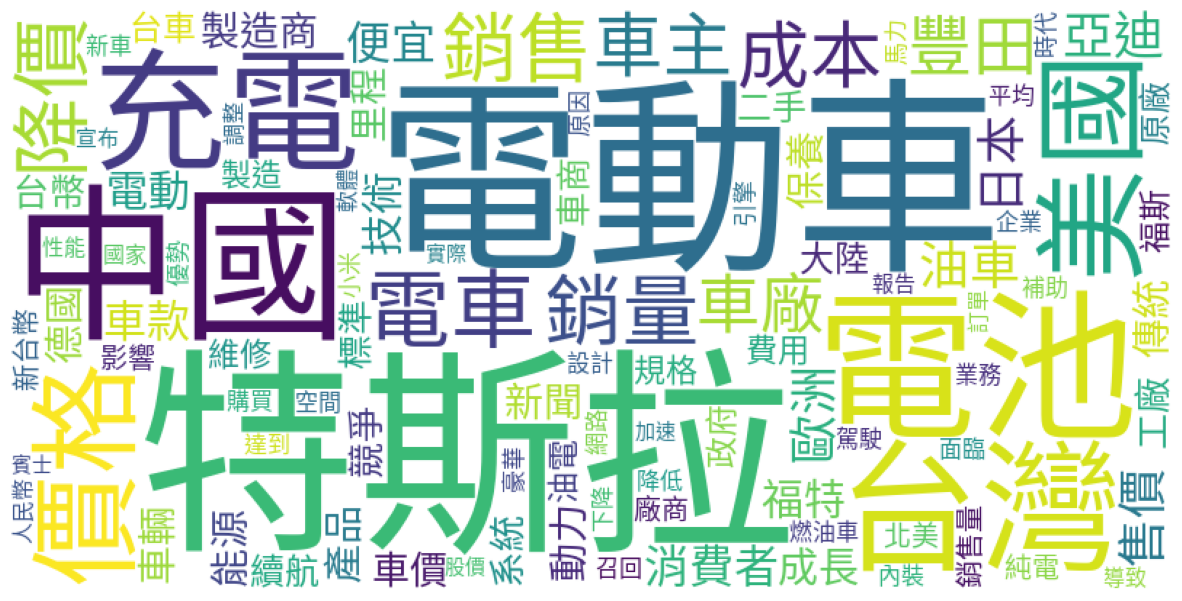

In [66]:
FontPath = './SourceHanSansTW-Regular.otf' # 設定字型
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 100)
wordcloud_nostop.generate_from_frequencies(freq_dict_nostop)

plt.figure(figsize = (15,12))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()